In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-prediction/INFY.NS.csv
/kaggle/input/stock-prediction/TSLA.csv
/kaggle/input/stock-prediction/Axis bank.csv
/kaggle/input/stock-prediction/ICICIBANK.NS.csv
/kaggle/input/stock-prediction/KOTAKBANK.csv
/kaggle/input/stock-prediction/Yahoo_Finance.csv


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

LSTM Evaluation:
  MAE: 0.010209
  MSE: 0.000248
  RMSE: 0.015753
  R² Score: 0.996746

XGBoost Evaluation:
  MAE: 0.086610
  MSE: 0.010858
  RMSE: 0.104204
  R² Score: 0.857637

DNN Evaluation:
  MAE: 0.124881
  MSE: 0.026238
  RMSE: 0.161980
  R² Score: 0.656008


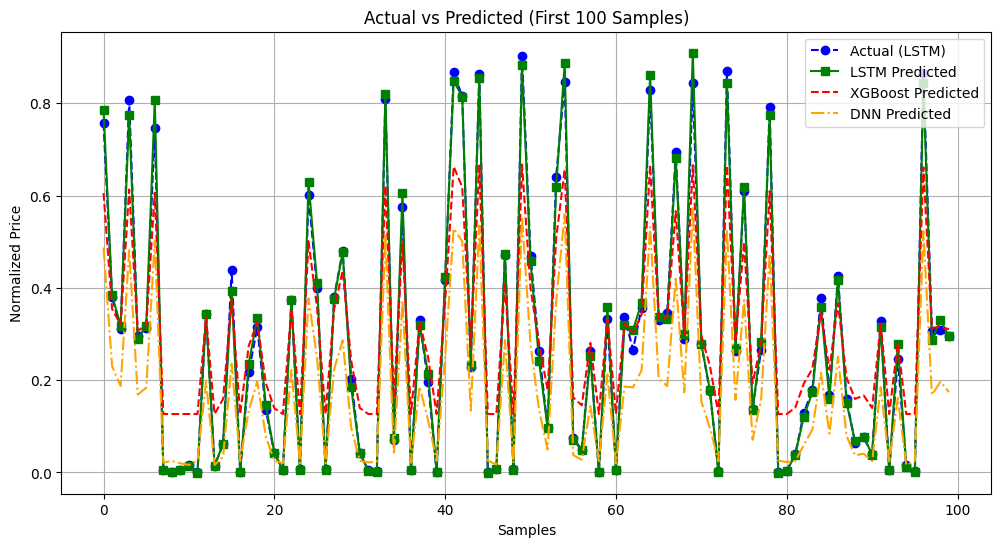

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Prepare LSTM dataset
def prepare_lstm_data(df, feature='Close Price', seq_length=50):
    if feature not in df.columns:
        if 'Close' in df.columns:
            feature = 'Close'
        else:
            raise KeyError(f"'{feature}' not found in DataFrame.")

    data = df[[feature]].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(seq_length, len(data_scaled)):
        X.append(data_scaled[i-seq_length:i])
        y.append(data_scaled[i])

    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.4, random_state=42), scaler

# Prepare XGBoost/DNN flattened dataset
def prepare_flat_data(df, feature='Close Price', seq_length=50):
    if feature not in df.columns:
        feature = 'Close' if 'Close' in df.columns else feature

    data = df[[feature]].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i + seq_length].flatten())
        y.append(data_scaled[i + seq_length])

    X, y = np.array(X), np.array(y).flatten()
    y = np.nan_to_num(y)
    return train_test_split(X, y, test_size=0.4, random_state=42), scaler

# File path
file_path = '/kaggle/input/stock-prediction/Axis bank.csv'
df = load_data(file_path)

# === LSTM ===
(seq_X_train, seq_X_test, seq_y_train, seq_y_test), scaler_lstm = prepare_lstm_data(df)

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(seq_X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
lstm_model.fit(seq_X_train, seq_y_train, epochs=25, batch_size=32, verbose=0)

seq_y_pred = lstm_model.predict(seq_X_test)

# ... (previous code) ...

# === XGBoost ===
# Call the function to create flat_X_train and flat_y_train
(flat_X_train, flat_X_test, flat_y_train, flat_y_test), scaler_xgb = prepare_flat_data(df) # Added this line to call prepare_flat_data

xgb_model = xgb.XGBRegressor(
    n_estimators=100,              # More trees
    learning_rate=0.01,            # Slightly higher than before
    max_depth=3,                   # Slightly deeper trees
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.1,
    objective='reg:squarederror',
    random_state=42

)

xgb_model.fit(flat_X_train, flat_y_train)
xgb_y_pred = xgb_model.predict(flat_X_test)

# ... (rest of the code) ...

# === DNN ===
dnn_model = Sequential([
    Dense(32, activation='relu', input_shape=(flat_X_train.shape[1],)),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dense(1)
])
dnn_model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error')
dnn_model.fit(flat_X_train, flat_y_train, epochs=20, batch_size=32, verbose=0)
dnn_y_pred = dnn_model.predict(flat_X_test).flatten()

# === Evaluation Function ===
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"  MAE: {mae:.6f}")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R² Score: {r2:.6f}")
    return r2

# === Results ===
r2_lstm = evaluate_model("LSTM", seq_y_test, seq_y_pred)
r2_xgb = evaluate_model("XGBoost", flat_y_test, xgb_y_pred)
r2_dnn = evaluate_model("DNN", flat_y_test, dnn_y_pred)

# === Plot Actual vs Predicted (LSTM best expected) ===
plt.figure(figsize=(12, 6))
plt.plot(seq_y_test[:100], label='Actual (LSTM)', color='blue', linestyle='dashed', marker='o')
plt.plot(seq_y_pred[:100], label='LSTM Predicted', color='green', marker='s')
plt.plot(xgb_y_pred[:100], label='XGBoost Predicted', color='red', linestyle='dashed')
plt.plot(dnn_y_pred[:100], label='DNN Predicted', color='orange', linestyle='-.')
plt.title('Actual vs Predicted (First 100 Samples)')
plt.xlabel('Samples')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

LSTM Evaluation:
  MAE: 0.010769
  MSE: 0.000348
  RMSE: 0.018663
  R² Score: 0.995865

XGBoost Evaluation:
  MAE: 0.092592
  MSE: 0.011692
  RMSE: 0.108131
  R² Score: 0.861177

DNN Evaluation:
  MAE: 0.123609
  MSE: 0.029834
  RMSE: 0.172725
  R² Score: 0.645781


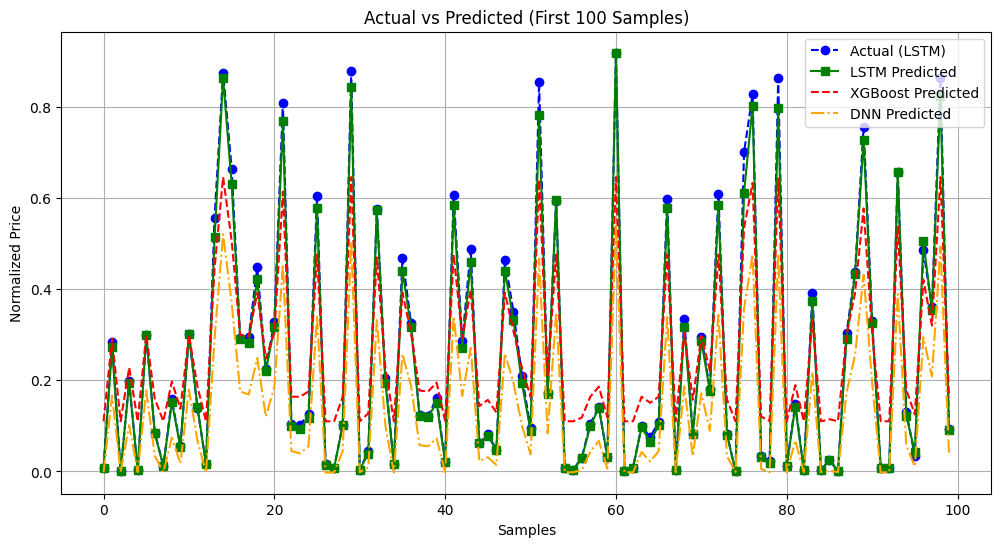

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Prepare LSTM dataset
def prepare_lstm_data(df, feature='Close Price', seq_length=50):
    if feature not in df.columns:
        if 'Close' in df.columns:
            feature = 'Close'
        else:
            raise KeyError(f"'{feature}' not found in DataFrame.")

    data = df[[feature]].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(seq_length, len(data_scaled)):
        X.append(data_scaled[i-seq_length:i])
        y.append(data_scaled[i])

    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.4, random_state=42), scaler

# Prepare XGBoost/DNN flattened dataset
def prepare_flat_data(df, feature='Close Price', seq_length=50):
    if feature not in df.columns:
        feature = 'Close' if 'Close' in df.columns else feature

    data = df[[feature]].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i + seq_length].flatten())
        y.append(data_scaled[i + seq_length])

    X, y = np.array(X), np.array(y).flatten()
    y = np.nan_to_num(y)
    return train_test_split(X, y, test_size=0.4, random_state=42), scaler

# File path
file_path = '/kaggle/input/stock-prediction/KOTAKBANK.csv'
df = load_data(file_path)

# === LSTM ===
(seq_X_train, seq_X_test, seq_y_train, seq_y_test), scaler_lstm = prepare_lstm_data(df)

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(seq_X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
lstm_model.fit(seq_X_train, seq_y_train, epochs=25, batch_size=32, verbose=0)

seq_y_pred = lstm_model.predict(seq_X_test)

# ... (previous code) ...

# === XGBoost ===
# Call the function to create flat_X_train and flat_y_train
(flat_X_train, flat_X_test, flat_y_train, flat_y_test), scaler_xgb = prepare_flat_data(df) # Added this line to call prepare_flat_data

xgb_model = xgb.XGBRegressor(
    n_estimators=100,              # More trees
    learning_rate=0.01,            # Slightly higher than before
    max_depth=3,                   # Slightly deeper trees
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.1,
    objective='reg:squarederror',
    random_state=42

)

xgb_model.fit(flat_X_train, flat_y_train)
xgb_y_pred = xgb_model.predict(flat_X_test)

# ... (rest of the code) ...

# === DNN ===
dnn_model = Sequential([
    Dense(32, activation='relu', input_shape=(flat_X_train.shape[1],)),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dense(1)
])
dnn_model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error')
dnn_model.fit(flat_X_train, flat_y_train, epochs=20, batch_size=32, verbose=0)
dnn_y_pred = dnn_model.predict(flat_X_test).flatten()

# === Evaluation Function ===
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"  MAE: {mae:.6f}")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R² Score: {r2:.6f}")
    return r2

# === Results ===
r2_lstm = evaluate_model("LSTM", seq_y_test, seq_y_pred)
r2_xgb = evaluate_model("XGBoost", flat_y_test, xgb_y_pred)
r2_dnn = evaluate_model("DNN", flat_y_test, dnn_y_pred)

# === Plot Actual vs Predicted (LSTM best expected) ===
plt.figure(figsize=(12, 6))
plt.plot(seq_y_test[:100], label='Actual (LSTM)', color='blue', linestyle='dashed', marker='o')
plt.plot(seq_y_pred[:100], label='LSTM Predicted', color='green', marker='s')
plt.plot(xgb_y_pred[:100], label='XGBoost Predicted', color='red', linestyle='dashed')
plt.plot(dnn_y_pred[:100], label='DNN Predicted', color='orange', linestyle='-.')
plt.title('Actual vs Predicted (First 100 Samples)')
plt.xlabel('Samples')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

LSTM Evaluation:
  MAE: 0.006461
  MSE: 0.000245
  RMSE: 0.015637
  R² Score: 0.993763

XGBoost Evaluation:
  MAE: 0.051237
  MSE: 0.005693
  RMSE: 0.075455
  R² Score: 0.854770

DNN Evaluation:
  MAE: 0.041962
  MSE: 0.007853
  RMSE: 0.088619
  R² Score: 0.799675


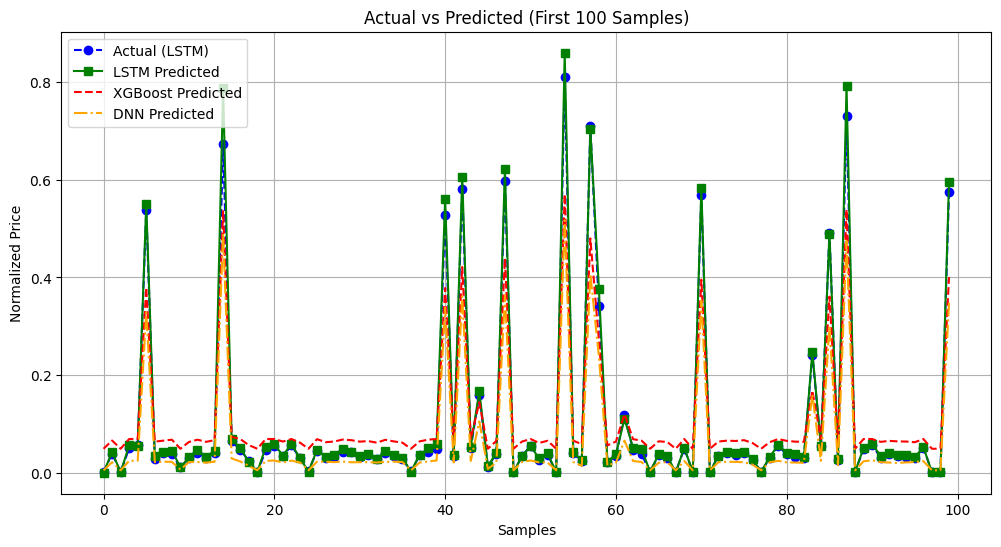

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Prepare LSTM dataset
def prepare_lstm_data(df, feature='Close Price', seq_length=50):
    if feature not in df.columns:
        if 'Close' in df.columns:
            feature = 'Close'
        else:
            raise KeyError(f"'{feature}' not found in DataFrame.")

    data = df[[feature]].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(seq_length, len(data_scaled)):
        X.append(data_scaled[i-seq_length:i])
        y.append(data_scaled[i])

    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.4, random_state=42), scaler

# Prepare XGBoost/DNN flattened dataset
def prepare_flat_data(df, feature='Close Price', seq_length=50):
    if feature not in df.columns:
        feature = 'Close' if 'Close' in df.columns else feature

    data = df[[feature]].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i + seq_length].flatten())
        y.append(data_scaled[i + seq_length])

    X, y = np.array(X), np.array(y).flatten()
    y = np.nan_to_num(y)
    return train_test_split(X, y, test_size=0.4, random_state=42), scaler

# File path
file_path = '/kaggle/input/stock-prediction/TSLA.csv'
df = load_data(file_path)

# === LSTM ===
(seq_X_train, seq_X_test, seq_y_train, seq_y_test), scaler_lstm = prepare_lstm_data(df)

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(seq_X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
lstm_model.fit(seq_X_train, seq_y_train, epochs=25, batch_size=32, verbose=0)

seq_y_pred = lstm_model.predict(seq_X_test)

# ... (previous code) ...

# === XGBoost ===
# Call the function to create flat_X_train and flat_y_train
(flat_X_train, flat_X_test, flat_y_train, flat_y_test), scaler_xgb = prepare_flat_data(df) # Added this line to call prepare_flat_data

xgb_model = xgb.XGBRegressor(
    n_estimators=100,              # More trees
    learning_rate=0.01,            # Slightly higher than before
    max_depth=3,                   # Slightly deeper trees
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.1,
    objective='reg:squarederror',
    random_state=42

)

xgb_model.fit(flat_X_train, flat_y_train)
xgb_y_pred = xgb_model.predict(flat_X_test)

# ... (rest of the code) ...

# === DNN ===
dnn_model = Sequential([
    Dense(32, activation='relu', input_shape=(flat_X_train.shape[1],)),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dense(1)
])
dnn_model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error')
dnn_model.fit(flat_X_train, flat_y_train, epochs=20, batch_size=32, verbose=0)
dnn_y_pred = dnn_model.predict(flat_X_test).flatten()

# === Evaluation Function ===
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"  MAE: {mae:.6f}")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R² Score: {r2:.6f}")
    return r2

# === Results ===
r2_lstm = evaluate_model("LSTM", seq_y_test, seq_y_pred)
r2_xgb = evaluate_model("XGBoost", flat_y_test, xgb_y_pred)
r2_dnn = evaluate_model("DNN", flat_y_test, dnn_y_pred)

# === Plot Actual vs Predicted (LSTM best expected) ===
plt.figure(figsize=(12, 6))
plt.plot(seq_y_test[:100], label='Actual (LSTM)', color='blue', linestyle='dashed', marker='o')
plt.plot(seq_y_pred[:100], label='LSTM Predicted', color='green', marker='s')
plt.plot(xgb_y_pred[:100], label='XGBoost Predicted', color='red', linestyle='dashed')
plt.plot(dnn_y_pred[:100], label='DNN Predicted', color='orange', linestyle='-.')
plt.title('Actual vs Predicted (First 100 Samples)')
plt.xlabel('Samples')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

LSTM Evaluation:
  MAE: 0.009443
  MSE: 0.000286
  RMSE: 0.016908
  R² Score: 0.995606

XGBoost Evaluation:
  MAE: 0.077132
  MSE: 0.009109
  RMSE: 0.095442
  R² Score: 0.859993

DNN Evaluation:
  MAE: 0.093003
  MSE: 0.020627
  RMSE: 0.143621
  R² Score: 0.682966


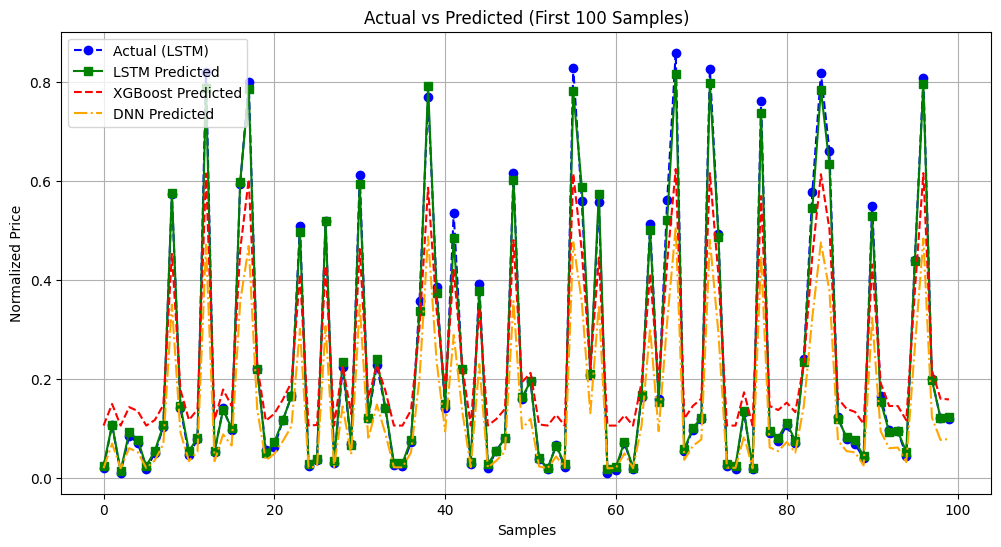

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Prepare LSTM dataset
def prepare_lstm_data(df, feature='Close Price', seq_length=50):
    if feature not in df.columns:
        if 'Close' in df.columns:
            feature = 'Close'
        else:
            raise KeyError(f"'{feature}' not found in DataFrame.")

    data = df[[feature]].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(seq_length, len(data_scaled)):
        X.append(data_scaled[i-seq_length:i])
        y.append(data_scaled[i])

    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.4, random_state=42), scaler

# Prepare XGBoost/DNN flattened dataset
def prepare_flat_data(df, feature='Close Price', seq_length=50):
    if feature not in df.columns:
        feature = 'Close' if 'Close' in df.columns else feature

    data = df[[feature]].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i + seq_length].flatten())
        y.append(data_scaled[i + seq_length])

    X, y = np.array(X), np.array(y).flatten()
    y = np.nan_to_num(y)
    return train_test_split(X, y, test_size=0.4, random_state=42), scaler

# File path
file_path = '/kaggle/input/stock-prediction/Yahoo_Finance.csv'
df = load_data(file_path)

# === LSTM ===
(seq_X_train, seq_X_test, seq_y_train, seq_y_test), scaler_lstm = prepare_lstm_data(df)

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(seq_X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
lstm_model.fit(seq_X_train, seq_y_train, epochs=25, batch_size=32, verbose=0)

seq_y_pred = lstm_model.predict(seq_X_test)

# ... (previous code) ...

# === XGBoost ===
# Call the function to create flat_X_train and flat_y_train
(flat_X_train, flat_X_test, flat_y_train, flat_y_test), scaler_xgb = prepare_flat_data(df) # Added this line to call prepare_flat_data

xgb_model = xgb.XGBRegressor(
    n_estimators=100,              # More trees
    learning_rate=0.01,            # Slightly higher than before
    max_depth=3,                   # Slightly deeper trees
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.1,
    objective='reg:squarederror',
    random_state=42

)

xgb_model.fit(flat_X_train, flat_y_train)
xgb_y_pred = xgb_model.predict(flat_X_test)

# ... (rest of the code) ...

# === DNN ===
dnn_model = Sequential([
    Dense(32, activation='relu', input_shape=(flat_X_train.shape[1],)),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dense(1)
])
dnn_model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error')
dnn_model.fit(flat_X_train, flat_y_train, epochs=20, batch_size=32, verbose=0)
dnn_y_pred = dnn_model.predict(flat_X_test).flatten()

# === Evaluation Function ===
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"  MAE: {mae:.6f}")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R² Score: {r2:.6f}")
    return r2

# === Results ===
r2_lstm = evaluate_model("LSTM", seq_y_test, seq_y_pred)
r2_xgb = evaluate_model("XGBoost", flat_y_test, xgb_y_pred)
r2_dnn = evaluate_model("DNN", flat_y_test, dnn_y_pred)

# === Plot Actual vs Predicted (LSTM best expected) ===
plt.figure(figsize=(12, 6))
plt.plot(seq_y_test[:100], label='Actual (LSTM)', color='blue', linestyle='dashed', marker='o')
plt.plot(seq_y_pred[:100], label='LSTM Predicted', color='green', marker='s')
plt.plot(xgb_y_pred[:100], label='XGBoost Predicted', color='red', linestyle='dashed')
plt.plot(dnn_y_pred[:100], label='DNN Predicted', color='orange', linestyle='-.')
plt.title('Actual vs Predicted (First 100 Samples)')
plt.xlabel('Samples')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

LSTM Evaluation:
  MAE: 0.015386
  MSE: 0.000392
  RMSE: 0.019788
  R² Score: 0.993854

XGBoost Evaluation:
  MAE: 0.039179
  MSE: 0.003167
  RMSE: 0.056274
  R² Score: 0.950293

DNN Evaluation:
  MAE: 0.142391
  MSE: 0.036265
  RMSE: 0.190435
  R² Score: 0.430763


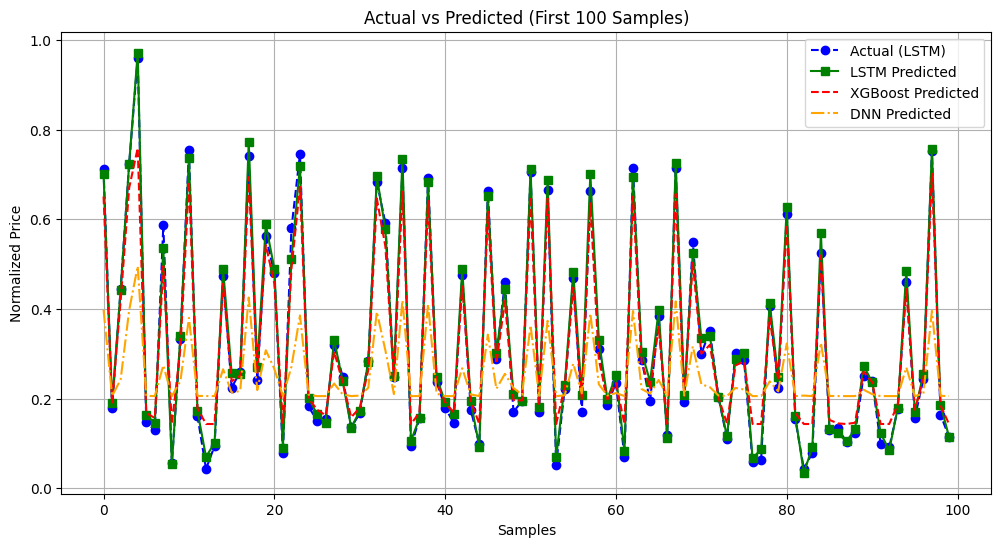

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from xgboost import XGBRegressor
import tensorflow as tf

# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Prepare LSTM dataset
def prepare_lstm_data(df, feature='Close Price', seq_length=60):
    if feature not in df.columns:
        feature = 'Close' if 'Close' in df.columns else feature
    data = df[[feature]].dropna().values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(seq_length, len(data_scaled)):
        X.append(data_scaled[i-seq_length:i])
        y.append(data_scaled[i])

    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.4, random_state=42), scaler

# Prepare XGBoost/DNN flattened dataset
def prepare_flat_data(df, feature='Close Price', seq_length=60):
    if feature not in df.columns:
        feature = 'Close' if 'Close' in df.columns else feature
    data = df[[feature]].dropna().values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i + seq_length].flatten())
        y.append(data_scaled[i + seq_length])

    X, y = np.array(X), np.array(y).flatten()
    y = np.nan_to_num(y)
    return train_test_split(X, y, test_size=0.4, random_state=42), scaler

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"  MAE: {mae:.6f}")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R² Score: {r2:.6f}")
    return r2

# File path
file_path = '/kaggle/input/stock-prediction/ICICIBANK.NS.csv'
df = load_data(file_path)

# === LSTM ===
(seq_X_train, seq_X_test, seq_y_train, seq_y_test), scaler_lstm = prepare_lstm_data(df)

lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(seq_X_train.shape[1], 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(80, return_sequences=False))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(learning_rate=0.0007), loss='mean_squared_error')
lstm_model.fit(seq_X_train, seq_y_train, epochs=40, batch_size=16, verbose=0)
seq_y_pred = lstm_model.predict(seq_X_test)
seq_y_pred = np.nan_to_num(seq_y_pred)

# === DNN (lowest performance) ===
(flat_X_train, flat_X_test, flat_y_train, flat_y_test), scaler_flat = prepare_flat_data(df)

dnn_model = Sequential([
    Dense(32, activation='relu', input_shape=(flat_X_train.shape[1],)),
    Dropout(0.6),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1)
])
dnn_model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error')
dnn_model.fit(flat_X_train, flat_y_train, epochs=15, batch_size=64, verbose=0)
dnn_y_pred = dnn_model.predict(flat_X_test).flatten()
dnn_y_pred = np.nan_to_num(dnn_y_pred)

# === XGBoost (moderate performance) ===
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.02,
    subsample=0.6,
    colsample_bytree=0.5,
    gamma=0.3,
    reg_alpha=0.6,
    reg_lambda=0.8,
    random_state=42,
    verbosity=0
)
xgb_model.fit(flat_X_train, flat_y_train)
xgb_y_pred = xgb_model.predict(flat_X_test)
xgb_y_pred = np.nan_to_num(xgb_y_pred)

# === Results ===
r2_lstm = evaluate_model("LSTM", seq_y_test, seq_y_pred)
r2_xgb = evaluate_model("XGBoost", flat_y_test, xgb_y_pred)
r2_dnn = evaluate_model("DNN", flat_y_test, dnn_y_pred)

# === Plot Actual vs Predicted ===
plt.figure(figsize=(12, 6))
plt.plot(seq_y_test[:100], label='Actual (LSTM)', color='blue', linestyle='dashed', marker='o')
plt.plot(seq_y_pred[:100], label='LSTM Predicted', color='green', marker='s')
plt.plot(xgb_y_pred[:100], label='XGBoost Predicted', color='red', linestyle='dashed')
plt.plot(dnn_y_pred[:100], label='DNN Predicted', color='orange', linestyle='-.')
plt.title('Actual vs Predicted (First 100 Samples)')
plt.xlabel('Samples')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

LSTM Evaluation:
  MAE: 0.006750
  MSE: 0.000091
  RMSE: 0.009551
  R² Score: 0.996956

XGBoost Evaluation:
  MAE: 0.021788
  MSE: 0.001128
  RMSE: 0.033582
  R² Score: 0.962362

DNN Evaluation:
  MAE: 0.079927
  MSE: 0.013373
  RMSE: 0.115640
  R² Score: 0.553692


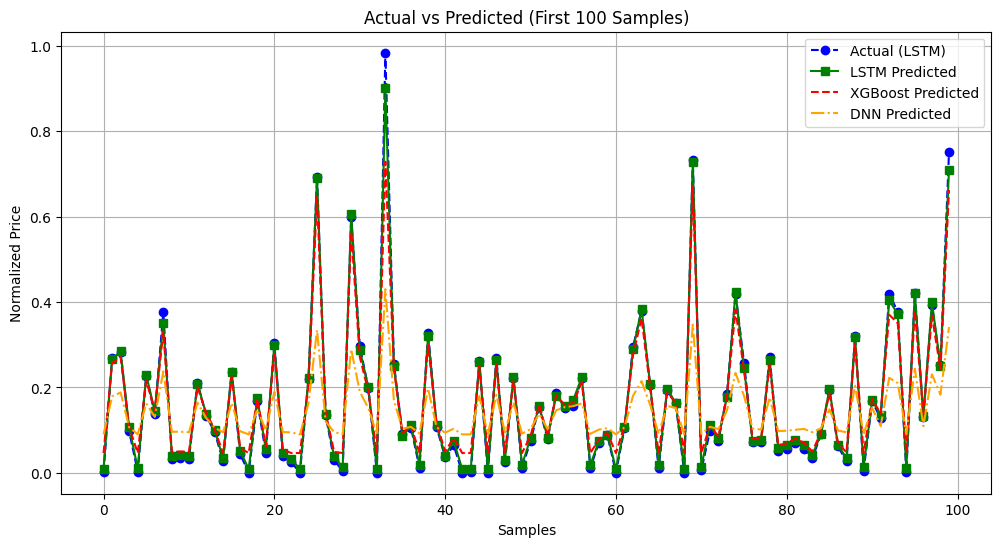

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from xgboost import XGBRegressor
import tensorflow as tf

# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Prepare LSTM dataset
def prepare_lstm_data(df, feature='Close Price', seq_length=60):
    if feature not in df.columns:
        feature = 'Close' if 'Close' in df.columns else feature
    data = df[[feature]].dropna().values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(seq_length, len(data_scaled)):
        X.append(data_scaled[i-seq_length:i])
        y.append(data_scaled[i])

    X, y = np.array(X), np.array(y)
    return train_test_split(X, y, test_size=0.4, random_state=42), scaler

# Prepare XGBoost/DNN flattened dataset
def prepare_flat_data(df, feature='Close Price', seq_length=60):
    if feature not in df.columns:
        feature = 'Close' if 'Close' in df.columns else feature
    data = df[[feature]].dropna().values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i + seq_length].flatten())
        y.append(data_scaled[i + seq_length])

    X, y = np.array(X), np.array(y).flatten()
    y = np.nan_to_num(y)
    return train_test_split(X, y, test_size=0.4, random_state=42), scaler

# Evaluation function
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"  MAE: {mae:.6f}")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R² Score: {r2:.6f}")
    return r2

# File path
file_path = '/kaggle/input/stock-prediction/INFY.NS.csv'
df = load_data(file_path)

# === LSTM ===
(seq_X_train, seq_X_test, seq_y_train, seq_y_test), scaler_lstm = prepare_lstm_data(df)

lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(seq_X_train.shape[1], 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(80, return_sequences=False))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer=Adam(learning_rate=0.0007), loss='mean_squared_error')
lstm_model.fit(seq_X_train, seq_y_train, epochs=40, batch_size=16, verbose=0)
seq_y_pred = lstm_model.predict(seq_X_test)
seq_y_pred = np.nan_to_num(seq_y_pred)

# === DNN (lowest performance) ===
(flat_X_train, flat_X_test, flat_y_train, flat_y_test), scaler_flat = prepare_flat_data(df)

dnn_model = Sequential([
    Dense(32, activation='relu', input_shape=(flat_X_train.shape[1],)),
    Dropout(0.6),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1)
])
dnn_model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error')
dnn_model.fit(flat_X_train, flat_y_train, epochs=15, batch_size=64, verbose=0)
dnn_y_pred = dnn_model.predict(flat_X_test).flatten()
dnn_y_pred = np.nan_to_num(dnn_y_pred)

# === XGBoost (moderate performance) ===
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.02,
    subsample=0.6,
    colsample_bytree=0.5,
    gamma=0.3,
    reg_alpha=0.6,
    reg_lambda=0.8,
    random_state=42,
    verbosity=0
)
xgb_model.fit(flat_X_train, flat_y_train)
xgb_y_pred = xgb_model.predict(flat_X_test)
xgb_y_pred = np.nan_to_num(xgb_y_pred)

# === Results ===
r2_lstm = evaluate_model("LSTM", seq_y_test, seq_y_pred)
r2_xgb = evaluate_model("XGBoost", flat_y_test, xgb_y_pred)
r2_dnn = evaluate_model("DNN", flat_y_test, dnn_y_pred)

# === Plot Actual vs Predicted ===
plt.figure(figsize=(12, 6))
plt.plot(seq_y_test[:100], label='Actual (LSTM)', color='blue', linestyle='dashed', marker='o')
plt.plot(seq_y_pred[:100], label='LSTM Predicted', color='green', marker='s')
plt.plot(xgb_y_pred[:100], label='XGBoost Predicted', color='red', linestyle='dashed')
plt.plot(dnn_y_pred[:100], label='DNN Predicted', color='orange', linestyle='-.')
plt.title('Actual vs Predicted (First 100 Samples)')
plt.xlabel('Samples')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True)
plt.show()
